## Time series Forcasting 

In [40]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
plt.style.use('bmh')


In [88]:
#Modeling and validation libraries
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


In [42]:
#read the files. 
train = pd.read_csv("Train.csv")
test  = pd.read_csv("Test.csv")

In [43]:
#duplicate the data file so it can be called later.
train_original = train.copy()
test_original  = test.copy()

In [44]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

In [45]:
#check the size of the data 
train.shape, test.shape

((18288, 3), (5112, 2))

In [46]:
#convert the date form from object to datetime format in the train and test data set.
train['Datetime']   = pd.to_datetime(train.Datetime, format ='%d-%m-%Y %H:%M')
test['Datetime']    = pd.to_datetime(test.Datetime, format ='%d-%m-%Y %H:%M')
train_original['Datetime']   = pd.to_datetime(train_original.Datetime, format ='%d-%m-%Y %H:%M')
test_original['Datetime']    = pd.to_datetime(test_original.Datetime, format ='%d-%m-%Y %H:%M')

## Feature Extration

### Use the hypothesis listed to make the feature extraction move. 

In [47]:
#We highlited that weekend will have less air travel than weekdays. 
for i in (train, test, train_original, test_original):
    i['year']   =   i.Datetime.dt.year
    i['month']  =   i.Datetime.dt.month
    i['day']    =   i.Datetime.dt.day
    i['Hour']   =   i.Datetime.dt.hour

In [48]:
#N.B To identify weekends 5 and 6 are weekendas
train['day of week'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']

In [49]:
#function to classify the records
#weekend is 1
#week day is 0
def rowclass(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1 
    else:
        return 0

#apply the function rowclass
temp2 = train['Datetime'].apply(rowclass)
train['week_day_end'] = temp2

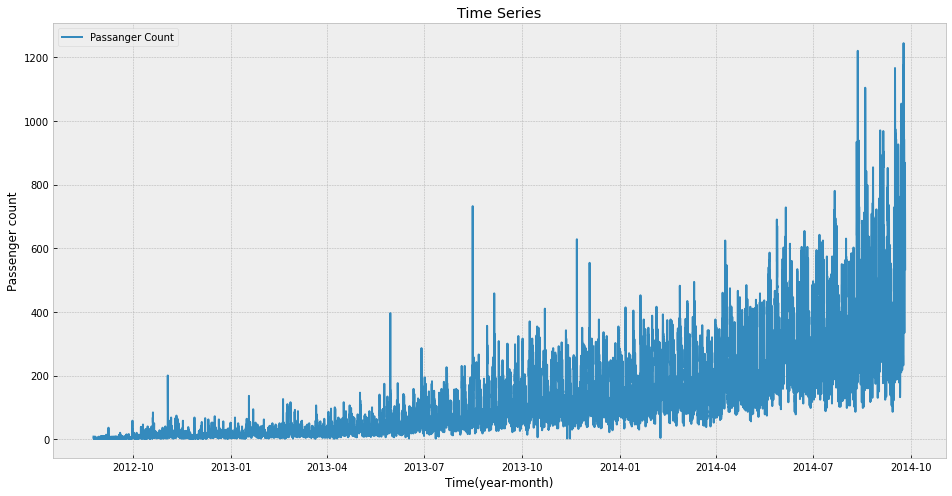

In [50]:
#view time series
train.index = train['Datetime']
#remove the id variable
trainN = train.drop('ID',1)

trainV = trainN['Count']
plt.figure(figsize = (16,8))
plt.plot(trainV, label ='Passanger Count')
plt.title('Time Series')
plt.xlabel('Time(year-month)')
plt.ylabel('Passenger count')
plt.legend(loc ='best')

### Exploratory Data Analysis

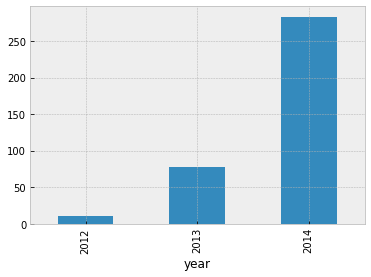

In [51]:
#Verify hypothesis 
train.groupby('year')['Count'].mean().plot.bar()

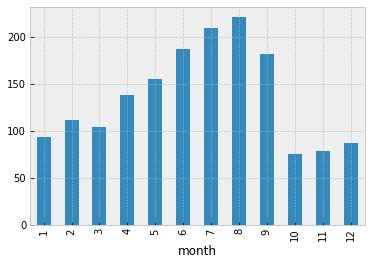

In [52]:
train.groupby('month')['Count'].mean().plot.bar()

This disproves out Hypothesis that during christmass the traffic is high

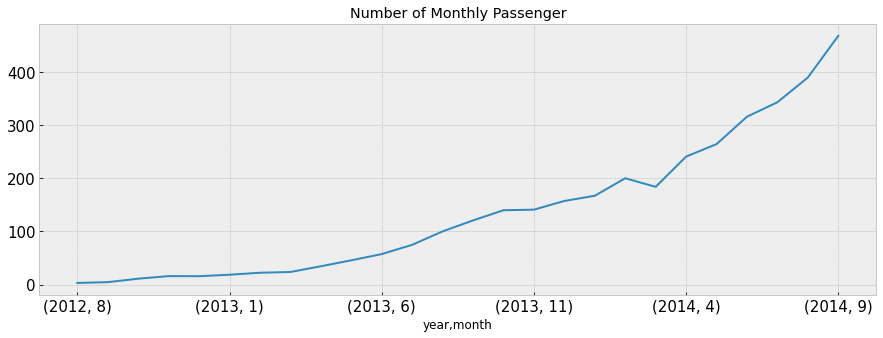

In [53]:
temp =train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize = (15, 5), title = 'Number of Monthly Passenger', fontsize =15)

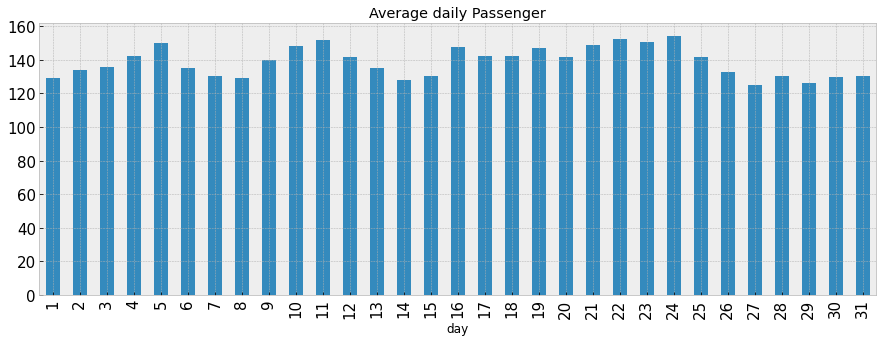

In [54]:
#observe the average dayily passenger in a month
train.groupby('day')['Count'].mean().plot.bar(figsize = (15, 5), title = 'Average daily Passenger', fontsize =15)

Not much insight is gotton from the daily chart.
we go ahead to plot the monthly chart

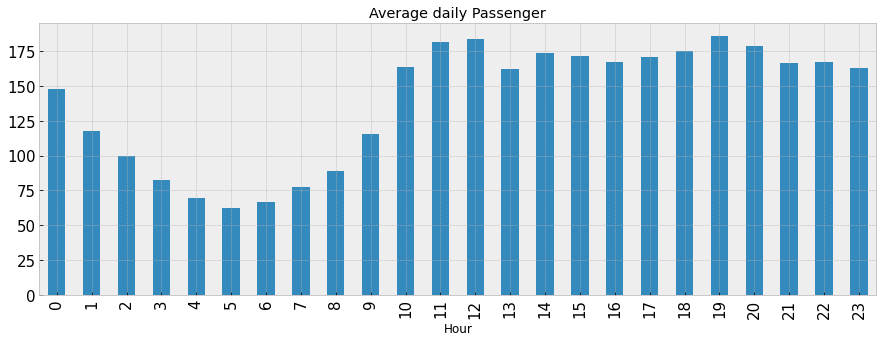

In [55]:
train.groupby('Hour')['Count'].mean().plot.bar(figsize = (15, 5), title = 'Average daily Passenger', fontsize =15)

### Note this provides a worthy insight unlike the daily average. the Hourly shows a peak  tile at 7pm. then a decline till Lowest at 5am. then stedy rise again. Points to note 
-7pm(19:00hrs) is the peak hour \
-5am is the les busiest hour \
-11 & 12PM are also busy hours 

Next to Validate another Hypothis which states that there will be more traffic in the week days compared to weekend

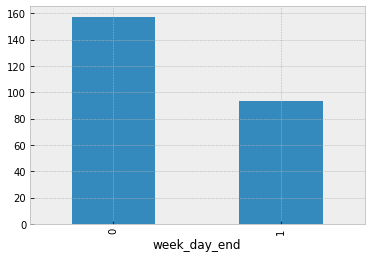

In [56]:
train.groupby('week_day_end')['Count'].mean().plot.bar()

As seen above the hypothesis is validated. the flight in the weekday is higher then the week end. 

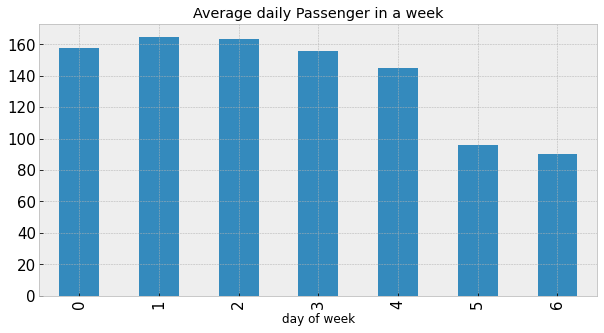

In [57]:
#average daily trafic in a week
train.groupby('day of week')['Count'].mean().plot.bar(figsize = (10, 5), title = 'Average daily Passenger in a week', fontsize =15)

The observation from this chart is that the hypothesis i correct. Customers are more on week days than week ends.

In [58]:
#drop the id column, it isn't necessary in this instance 
train =train.drop('ID',1)

In [59]:
train.Timestamp = pd.to_datetime(train.Datetime, format ='%d-%m-%Y %H:%M')
train.index =train.Timestamp

In [60]:
#hourly time series
hourly = train.resample('H').mean()
#convert to daily mean
daily = train.resample('D').mean()
#convert to weekly mean
weekly = train.resample('W').mean()
#convert to monthly mean
Monthly = train.resample('M').mean()

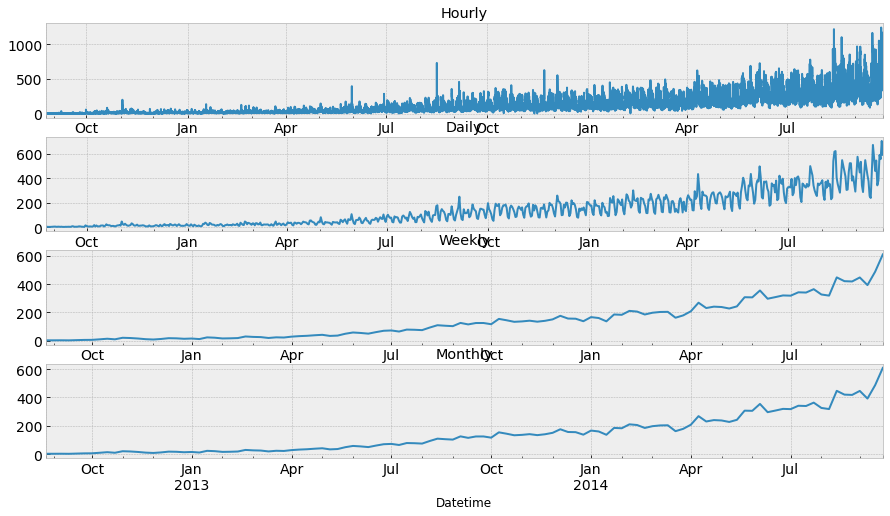

In [61]:
#plot to view the various charts
fig, axs = plt.subplots(4,1)
hourly.Count.plot(figsize =(15,8), title ='Hourly', fontsize =14, ax =axs[0])
daily.Count.plot(figsize =(15,8), title ='Daily', fontsize =14, ax =axs[1])
weekly.Count.plot(figsize = (15,8), title ='Weekly', fontsize = 14, ax =axs[2])
weekly.Count.plot(figsize =(15,8), title ='Monthly', fontsize = 14, ax =axs[3])

plt.show()

The chart becomes smoother as it increase form daily to weekly and monthly.
htw best time series to use for the test data set is daily. 

The Hypothesis has being fully validated. 
Just one was refuted 

Split the data set

In [62]:
#split the data into Train and validation 
#choose 4months for validation to accuratly cover all the possible data points.
Train = train.loc['2012-08-25': '2014-06-24'] 
valid = train.loc['2014-06-25':'2014-09-25']



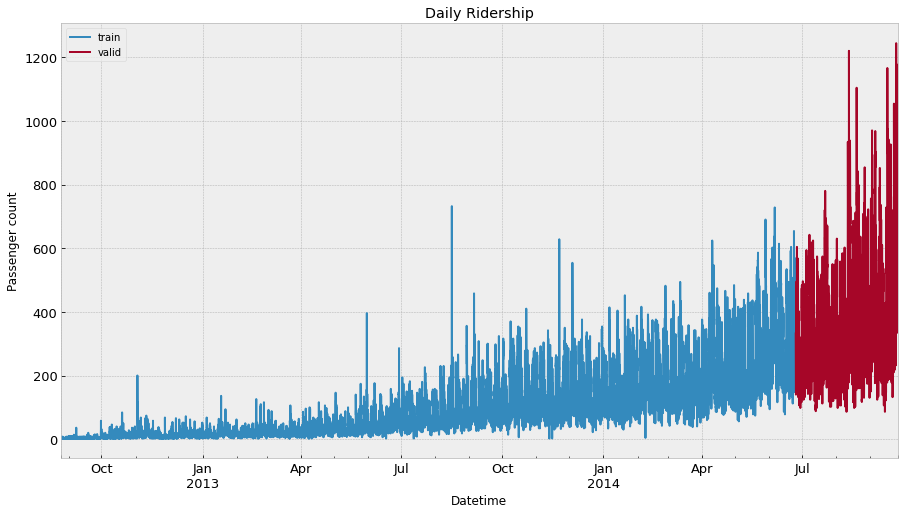

In [63]:

#Plot to visualize the train and the validation data
Train.Count.plot(figsize =(15,8), title ='Daily Ridership', fontsize =14,
label ='train')
valid.Count.plot(figsize =(15,8), title ='Daily Ridership', fontsize =13,
label ='valid')
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

Modelling technique
 For modelling in this Time series we shall look out four method.\ 
-Naive Approach\
-Moving average\
-Simple Exponential Smoothing\
-Holts’S Linear Trend

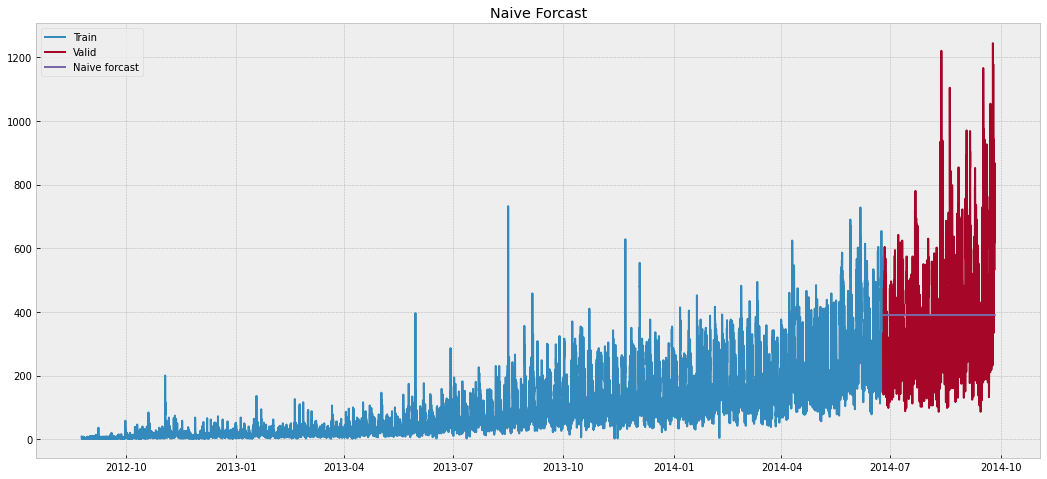

In [64]:
#Naive Approach
tt =np.asarray(Train.Count)
y_hat =valid.copy()
y_hat['naive'] = tt[len(tt)-1]
plt.figure(figsize=(18,8))
plt.plot(Train.index, Train['Count'], label ='Train')
plt.plot(valid.index, valid['Count'], label ='Valid')
plt.plot(y_hat.index, y_hat['naive'], label ='Naive forcast')
plt.legend(loc ='best')
plt.title('Naive Forcast')
plt.show()

The Naive prediction is the horizontal line at the validation data set

In [65]:
#Calculate the RMSE 
rms = sqrt(mse(valid.Count, y_hat.naive))
print(rms)

186.37368520699056


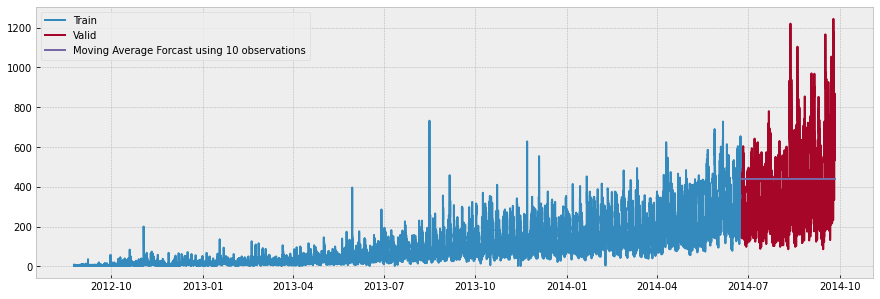

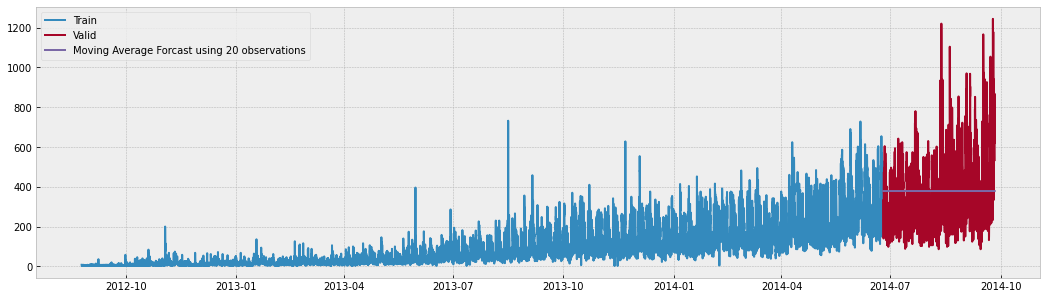

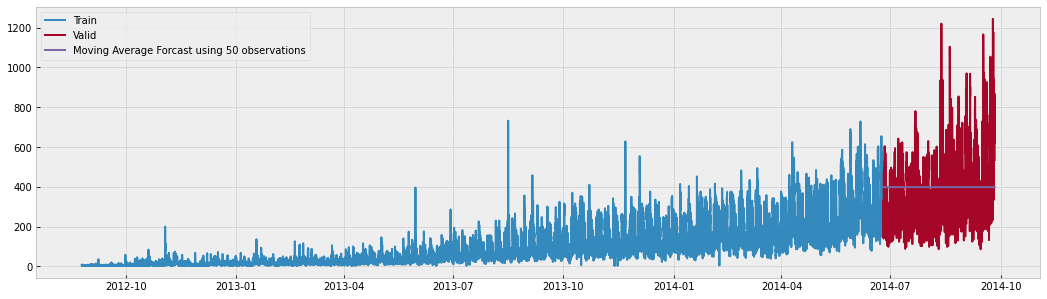

In [71]:
# Trying the seecond Moving Average Approach
#taking the average of a few point 10, 20, 50
y_hat_avg =valid.copy()
y_hat_avg['moving_avg_forcast'] =  Train['Count'].rolling(10).mean().iloc[-1]
#average of the last 10 observations 
plt.figure(figsize =(15,5))
plt.plot(Train['Count'], label ='Train')
plt.plot(valid['Count'], label ='Valid')
plt.plot(y_hat_avg['moving_avg_forcast'], label ='Moving Average Forcast using 10 observations')
plt.legend(loc='best')
plt.show()
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forcast'] = Train['Count'].rolling(20).mean().iloc[-1]
#average for the last 20 observations
plt.figure(figsize=(18,5))
plt.plot(Train['Count'], label ='Train')
plt.plot(valid['Count'], label ='Valid')
plt.plot(y_hat_avg['moving_avg_forcast'], label ='Moving Average Forcast using 20 observations')
plt.legend(loc='best')
plt.show()

y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forcast'] = Train['Count'].rolling(50).mean().iloc[-1]
#average for the last 50 observations
plt.figure(figsize=(18,5))
plt.plot(Train['Count'], label ='Train')
plt.plot(valid['Count'], label ='Valid')
plt.plot(y_hat_avg['moving_avg_forcast'], label ='Moving Average Forcast using 50 observations')
plt.legend(loc='best')
plt.show()

In [72]:
#Calculate the RMSE 
rms = sqrt(mse(valid.Count, y_hat_avg.moving_avg_forcast))
print(rms)

186.5773761711873


Simple Exponential smoothing model



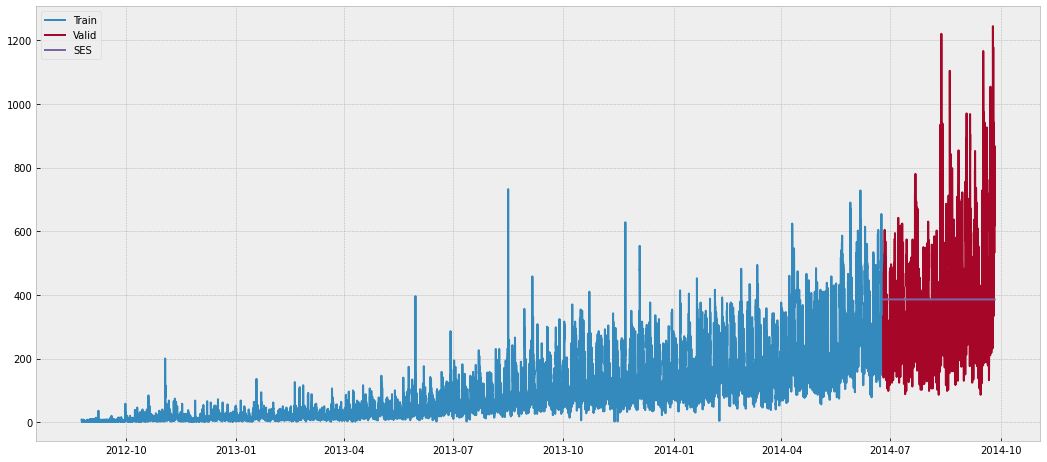

In [86]:
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level =0.6, optimized =False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(18,8))
plt.plot(Train['Count'], label ='Train')
plt.plot(valid['Count'], label ='Valid')
plt.plot(y_hat_avg['SES'], label ='SES')
plt.legend(loc='best')
plt.show()

In [87]:
#Calculate the RMSE 
rms = sqrt(mse(valid.Count, y_hat_avg.SES))
print(rms)

186.40944652452376


Holt's Linear Trens Model

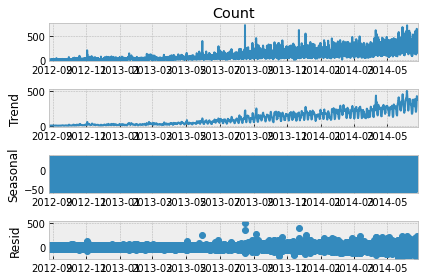

In [94]:
sm.tsa.seasonal_decompose(Train.Count).plot()
result =sm.tsa.stattools.adfuller(train.Count)
plt.show()

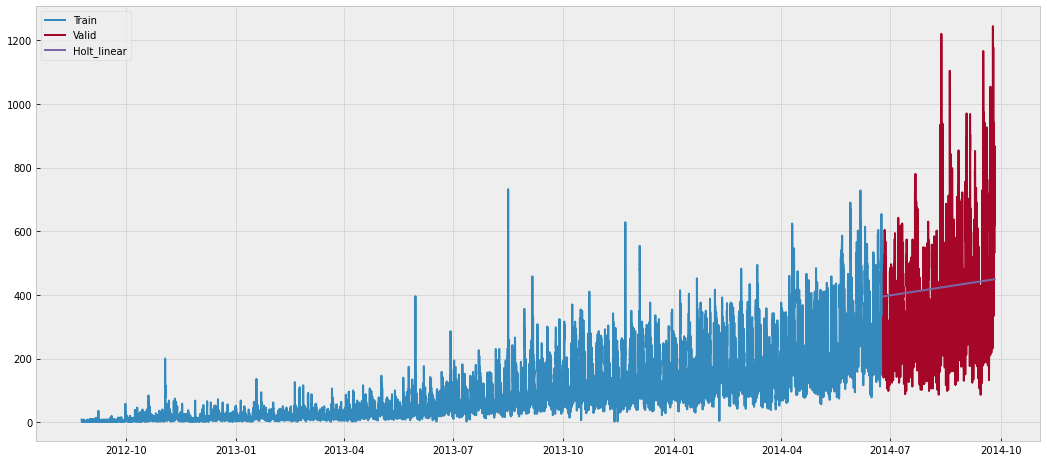

In [104]:
y_hat_avg = valid.copy()
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level =0.4, smoothing_slope = 0 ) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))
plt.figure(figsize=(18,8))
plt.plot(Train['Count'], label ='Train')
plt.plot(valid['Count'], label ='Valid')
plt.plot(y_hat_avg['Holt_linear'], label ='Holt_linear')
plt.legend(loc='best')
plt.show()

In [105]:
rms_holt = sqrt(mean_squared_error(valid.Count,y_hat_avg.Holt_linear))
print(rms_holt)


185.04309401170406


Rms value decreased we can now go further for prediction